In [62]:
import os

import pandas as pd
import geopandas as gpd

pd.options.mode.chained_assignment = None

import shapely
from shapely.geometry import LineString

from gtfs_data import GTFSData

data_dir = r'Q:\SACSIM23\Network\TransitNetwork\GTFS\SRTD'
os.chdir(data_dir)

gtfs = GTFSData(gtfs_dir=data_dir, data_year=2020)


# update strings to date time format
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[gtfs.df_stoptimes['arrival_time'] < '24:00:00']
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[gtfs.df_stoptimes['departure_time'] < '24:00:00']
gtfs.df_stoptimes[gtfs.f_depart_time] = pd.to_datetime(gtfs.df_stoptimes[gtfs.f_depart_time])
gtfs.df_stoptimes[gtfs.f_arrive_time] = pd.to_datetime(gtfs.df_stoptimes[gtfs.f_arrive_time])

# IMPORTANTLY, probably need to only include stops with arrival and departure times
gtfs.df_stoptimes = gtfs.df_stoptimes.loc[pd.notnull(gtfs.df_stoptimes['arrival_time'])]


In [83]:
gtfs.df_stoptimes.loc[gtfs.df_stoptimes['trip_id'] == 840400].head(10)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,840400,2023-01-15 21:44:00,2023-01-15 21:44:00,1184,1,0,0
1,840400,2023-01-15 21:44:00,2023-01-15 21:44:00,3301,2,0,0
2,840400,2023-01-15 21:45:00,2023-01-15 21:45:00,1187,3,0,0
3,840400,2023-01-15 21:45:00,2023-01-15 21:45:00,1188,4,0,0
4,840400,2023-01-15 21:46:00,2023-01-15 21:46:00,1189,5,0,0
5,840400,2023-01-15 21:47:00,2023-01-15 21:47:00,1190,6,0,0
6,840400,2023-01-15 21:48:00,2023-01-15 21:48:00,1191,7,0,0
7,840400,2023-01-15 21:48:00,2023-01-15 21:48:00,1192,8,0,0
8,840400,2023-01-15 21:49:00,2023-01-15 21:49:00,1193,9,0,0
9,840400,2023-01-15 21:50:00,2023-01-15 21:50:00,1195,10,0,0


In [70]:
# for a single trip, get geometry of its trip line shape and geom of stops made on that trip

test_trip_id = 840400 # 't_1063569_b_25331_tn_1'
df_test_trip = gtfs.df_trips.loc[gtfs.df_trips['trip_id'] == test_trip_id]

# create geodataframe of the test trip, with trip data and trip shape
gdf_test_tripshp = df_test_trip.join(gtfs.gdf_lineshps, on='shape_id')
gdf_test_tripshp = gpd.GeoDataFrame(gdf_test_tripshp, geometry='geometry') 

# make point gdf of stop locations along the trip shape
gdf_test_stops = df_test_trip.merge(gtfs.df_stoptimes, on='trip_id') \
                .merge(gtfs.gdf_stops, on='stop_id') \
                [['trip_id', 'stop_id', 'stop_sequence', 'geometry']] \
                .sort_values(by='stop_sequence')
gdf_test_stops = gpd.GeoDataFrame(gdf_test_stops, geometry='geometry') # need this to make geo df instead of regular df


In [71]:
gdf_test_stops.head()
# gdf_test_stops.to_file(r'C:\Users\dconly\Desktop\Temporary\geopandas-v-sedf\test_stops.shp')

,trip_id,stop_id,stop_sequence,geometry
0,840400,1184,1,POINT (6770840.747 2009989.278)
1,840400,3301,2,POINT (6770522.910 2009788.961)
2,840400,1187,3,POINT (6769355.713 2009772.670)
3,840400,1188,4,POINT (6767905.579 2009723.589)
4,840400,1189,5,POINT (6766646.877 2009689.941)


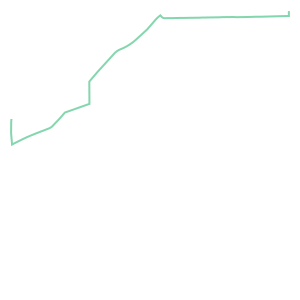

In [118]:
# segments[1]
gdf_segments['geometry'][0]

In [109]:
# split trip's line by trip's stop points

stops = list(gdf_test_stops['stop_sequence'])
stop_pairs = [(stops[i], stops[i+1]) for i, j in enumerate(stops) if i+1 < len(stops)]

segment_data = []

for pair in stop_pairs:
    # pair of stop points
    gdf_pair = gdf_test_stops.loc[gdf_test_stops['stop_sequence'].isin(pair)]

    # union all geometries
    line = gdf_test_tripshp.geometry[0]
    coords = gdf_pair.geometry.unary_union

    # snap and split coords on line
    # returns GeometryCollection
    split_line = shapely.ops.split(line, shapely.ops.snap(coords, line, tolerance=100.0))

    # transform Geometry Collection to GeoDataFrame
    segments = [feature for feature in split_line]

    gdf_segments = gpd.GeoDataFrame(
        list(range(len(segments))), geometry=segments)
    
    gdf_segments.columns = ['index', 'geometry']
    
    # get the line segment that corresponse to the portion between the two stops, not before or after them
    line_seg = gdf_segments.loc[gdf_segments.index == 1].set_crs(epsg=gtfs.epsg_sacog)

    # add trip id to segment
    line_seg['trip_id'] = test_trip_id

    # select the 2 stops closest to the segment
    gdf_pair['dist_to_line'] = gdf_pair.distance(line_seg)
    gdf_pair = gdf_pair.sort_values(by=['dist_to_line'])[:2]
    gdf_pair = gdf_pair.sort_values(by=['stop_sequence'])

    # start dict of segment data
    seg_data = {}

    # join segment table to stop time table
    jn = gdf_pair.merge(gtfs.df_stoptimes, on=['trip_id', 'stop_id', 'stop_sequence'], \
                        suffixes=('', 'y'))

    stop1_data = jn.iloc[0]
    stop2_data = jn.iloc[1]

    seg_data['begin_stop'] = stop1_data['stop_id']
    seg_data['end_stop'] = stop2_data['stop_id']
    seg_data['seg_len_mi'] = line_seg.length.mean() / 5280
    seg_data['seg_start_time'] = stop1_data['departure_time']
    seg_data['seg_end_time'] = stop2_data['arrival_time']
    seg_data['duration_mins'] = (seg_data['seg_end_time'] - seg_data['seg_start_time']).seconds / 60
    seg_data['speed_mph'] = -1 if seg_data['duration_mins'] == 0 else \
        seg_data['seg_len_mi'] / (seg_data['duration_mins'] / 60)
    seg_data['geometry'] = line_seg['geometry'][1]
    
    segment_data.append(seg_data)



C:\Users\dconly\AppData\Local\ESRI\conda\envs\arcgispro-jul052022\lib\site-packages\geopandas\base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


KeyError: 1

In [110]:
seg_data

{'begin_stop': 1184,
 'end_stop': 3301,
 'seg_len_mi': nan,
 'seg_start_time': Timestamp('2023-01-15 21:44:00'),
 'seg_end_time': Timestamp('2023-01-15 21:44:00'),
 'duration_mins': 0.0,
 'speed_mph': -1}

In [111]:
test_gdf = gpd.GeoDataFrame(segment_data)
test_gdf # [['begin_stop', 'end_stop']]

""


In [112]:

test_gdf['seg_start_time'] = test_gdf['seg_start_time'].astype('str')
test_gdf['seg_end_time'] = test_gdf['seg_end_time'].astype('str')
print(test_gdf.info())
test_outfile = r'C:\Users\dconly\Desktop\Temporary\geopandas-v-sedf\trip_segs.shp'
test_gdf.to_file(test_outfile)

KeyError: 'seg_start_time'

In [18]:
stops = list(gdf_test_stops['stop_sequence'])
stop_pairs = [(stops[i], stops[i+1]) for i, j in enumerate(stops) if i+1 < len(stops)]

[(1, 6), (6, 15), (15, 21), (21, 24), (24, 27), (27, 30)]

In [19]:
list(gdf_test_stops['stop_sequence'])

[1, 6, 15, 21, 24, 27, 30]

<AxesSubplot:>

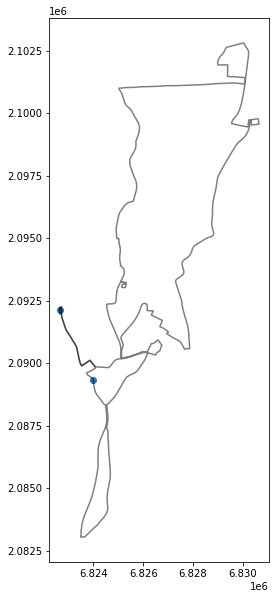

In [34]:
# ax = gdf_segments.loc[gdf_segments.index == 0].plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ax = gdf_segments.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
df_nearest_seg = gdf_test_stops.loc[gdf_test_stops['segtouch'] < 100]
first_pair.plot(ax=ax)